# PAMAP2 - CBAM


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torchsummary import summary
from sklearn.manifold import TSNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        ys.append(stats.mode(labels, keepdims=True)[0][0])
        Xs.append(x)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

def prepare_data_split(df, time_steps, steps, activity_mapping):
    X = df.drop(columns=['activityID', 'subject'])
    y = df['activityID'].map(activity_mapping)
    X_seq, y_seq = create_dataset(X, y, time_steps, steps)
    return X_seq, y_seq.flatten()

In [ ]:
class PAMAP2Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# 1D 채널 어텐션 모듈
class ChannelAttention1D(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention1D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        # 1x1 Conv를 사용한 공유 MLP 구현
        self.shared_mlp = nn.Sequential(
            nn.Conv1d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        # avg_out + max_out 후 sigmoid 적용
        attention_map = self.sigmoid(avg_out + max_out)
        # 원본 입력 x와 채널별 가중치 맵을 곱함 (브로드캐스팅)
        return x * attention_map.expand_as(x)

In [ ]:
# 1D 공간 어텐션 모듈
class SpatialAttention1D(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention1D, self).__init__()
        # 'same' 패딩을 위해 커널 크기는 홀수여야 함
        assert kernel_size % 2 == 1, "Kernel size must be odd"
        padding = (kernel_size - 1) // 2

        # 채널(avg, max)을 따라 concat된 2개 채널을 1개로 줄이는 Conv
        self.conv = nn.Conv1d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 채널 차원으로 풀링 (dim=1)
        avg_out = torch.mean(x, dim=1, keepdim=True) # (B, 1, L)
        max_out, _ = torch.max(x, dim=1, keepdim=True) # (B, 1, L)

        # 두 맵을 채널 차원으로 연결
        concatenated = torch.cat([avg_out, max_out], dim=1) # (B, 2, L)

        # Conv 연산 및 Sigmoid
        attention_map = self.sigmoid(self.conv(concatenated)) # (B, 1, L)
        # 원본 입력 x와 공간별 가중치 맵을 곱함 (브로드캐스팅)
        return x * attention_map.expand_as(x)

In [ ]:
# 1D CBAM 모듈 (채널 -> 공간 순차 적용)
class CBAM1D(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM1D, self).__init__()
        self.channel_attention = ChannelAttention1D(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention1D(kernel_size)

    def forward(self, x):
        # 채널 어텐션 적용
        x_refined = self.channel_attention(x)
        # 공간 어텐션 적용
        x_final = self.spatial_attention(x_refined)
        return x_final

In [ ]:
class BasicBlock1D_CBAM(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction_ratio=16):
        super(BasicBlock1D_CBAM, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        # 잔차 연결 직전에 CBAM 적용
        self.cbam = CBAM1D(out_channels, reduction_ratio)

        # Shortcut 경로 (Stride가 1이 아니거나 입력/출력 채널 수가 다를 때 차원 맞춰주기)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.cbam(out)
        out += shortcut
        out = self.relu(out)
        return out

In [ ]:
class ResNet1D_CBAM(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(ResNet1D_CBAM, self).__init__()
        self.in_channels = 64 # Stem 통과 후 채널 수

        # Stem
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet
        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 192, blocks=2, stride=2)
        self.layer4 = self._make_layer(192, 256, blocks=2, stride=2)

        # 3. Classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock1D_CBAM(in_channels, out_channels, stride=stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock1D_CBAM(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_pool(x)
        x = x.squeeze(-1)
        x = self.dropout(x)

        output = self.classifier(x)
        return output

    def get_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = x.squeeze(-1)
        return x

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        data = data.permute(0, 2, 1)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 2, 1)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

LOOSV(Leave-One-Out-Subject-Validation)
- LOSO(Leave-One-Subject-Out)과 동일한 개념
- 피험자 한 명의 데이터를 테스트셋으로 번갈아 가며 사용
- Protocol_subject101, 102, 105, 106, 108을 제외한 피험자는 모든 클래스가 포함되어 있지 않아서 테스트 데이터로 부적합하다고 판단. 따라서 101, 102, 105, 106, 108만 LOOSV에 포함함

In [ ]:
# Start the main LOSO logic
# Load data
df = pd.read_csv('/content/drive/MyDrive/AI_data/PAMAP2/PAMAP2_integrated_data.csv')

# Handle NaN values and map activities
activity_mapping = {
    1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
    12: 7, 13: 8, 16: 9, 17: 10, 24: 11
}
df = df[df['activityID'].isin(activity_mapping.keys())]

df_list = []
for activity_id in df['activityID'].unique():
    activity_df = df[df['activityID'] == activity_id].copy()
    activity_df[activity_df.select_dtypes(exclude='object').columns] = (
        activity_df.select_dtypes(exclude='object').interpolate(method='linear')
    )
    activity_df = activity_df.ffill().bfill()
    df_list.append(activity_df)

df_processed = pd.concat(df_list, ignore_index=True)

In [ ]:
# Define constants
TIME_STEPS = 100
STEPS = 50
num_epochs = 100
patience = 20

# LOSO Subjects
loso_test_subjects = ['Protocol_subject101', 'Protocol_subject102', 'Protocol_subject105', 'Protocol_subject106', 'Protocol_subject108']
all_subjects = df_processed['subject'].unique().tolist()

# Lists to store results across all folds
all_preds = []
all_labels = []
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_X_test = []

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# LOSO Loop
for fold_idx, test_subject in enumerate(loso_test_subjects):
    print(f"--- Starting LOSO Fold {fold_idx + 1}/{len(loso_test_subjects)}: Test Subject: {test_subject} ---")

    # Set up training, validation, and test sets for the current fold
    if test_subject == 'Protocol_subject105':
        val_subject = 'Protocol_subject106'
    else:
        val_subject = 'Protocol_subject105'

    train_subjects = [s for s in all_subjects if s not in [test_subject, val_subject]]

    train_df = df_processed[df_processed['subject'].isin(train_subjects)].copy()
    val_df = df_processed[df_processed['subject'] == val_subject].copy()
    test_df = df_processed[df_processed['subject'] == test_subject].copy()

    # Scale data
    features_to_scale = df_processed.columns.drop(['subject', 'activityID'])
    scaler = MinMaxScaler()
    train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
    val_df[features_to_scale] = scaler.transform(val_df[features_to_scale])
    test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

    # Prepare data for PyTorch
    X_train, y_train = prepare_data_split(train_df, TIME_STEPS, STEPS, activity_mapping)
    X_val, y_val = prepare_data_split(val_df, TIME_STEPS, STEPS, activity_mapping)
    X_test, y_test = prepare_data_split(test_df, TIME_STEPS, STEPS, activity_mapping)
    all_X_test.append(X_test)

    train_dataset = PAMAP2Dataset(X_train, y_train)
    val_dataset = PAMAP2Dataset(X_val, y_val)
    test_dataset = PAMAP2Dataset(X_test, y_test)

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Re-initialize model, criterion, and optimizer for each fold
    input_features = X_train.shape[2]
    num_classes = len(np.unique(y_train))
    model = ResNet1D_CBAM(num_classes, input_features).to(device)

     # Print summary for the first fold only
    if fold_idx == 0:
        print("\n--- Model Summary (Fold 1) ---")
        summary(model, input_size=(input_features, TIME_STEPS))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, min_lr=1e-5)

    best_val_loss = float('inf')
    patience_counter = 0

    fold_train_losses, fold_val_losses = [], []
    fold_train_accuracies, fold_val_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_train_accuracies.append(train_acc)
        fold_val_accuracies.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'PAMAP2_CBAM_best_fold_{fold_idx}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered for fold {fold_idx+1} after {epoch+1} epochs')
                break

    all_train_losses.append(fold_train_losses)
    all_val_losses.append(fold_val_losses)
    all_train_accuracies.append(fold_train_accuracies)
    all_val_accuracies.append(fold_val_accuracies)

    # Evaluation on the test set
    model.load_state_dict(torch.load(f'PAMAP2_CBAM_best_fold_{fold_idx}.pth'))
    model.eval()
    fold_preds = []
    fold_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 2, 1)
            output = model(data)
            _, predicted = torch.max(output, 1)
            fold_preds.extend(predicted.cpu().numpy())
            fold_labels.extend(target.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

print("\nTraining completed!")

Using device: cuda
--- Starting LOSO Fold 1/5: Test Subject: Protocol_subject101 ---

--- Model Summary (Fold 1) ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 50]          23,744
       BatchNorm1d-2               [-1, 64, 50]             128
              ReLU-3               [-1, 64, 50]               0
         MaxPool1d-4               [-1, 64, 25]               0
            Conv1d-5               [-1, 64, 25]          12,288
       BatchNorm1d-6               [-1, 64, 25]             128
              ReLU-7               [-1, 64, 25]               0
            Conv1d-8               [-1, 64, 25]          12,288
       BatchNorm1d-9               [-1, 64, 25]             128
AdaptiveAvgPool1d-10                [-1, 64, 1]               0
           Conv1d-11                 [-1, 4, 1]             256
             ReLU-12                 [-1, 4, 1]   

In [ ]:
# 마지막 폴드에서 저장한 모델 로드
last_fold_idx = len(loso_test_subjects) - 1
model.load_state_dict(torch.load(f'PAMAP2_CBAM_best_fold_{last_fold_idx}.pth'))

# 마지막 폴드의 train_loader를 사용하여 훈련 데이터에 대한 성능을 측정
train_loss, train_acc = validate_epoch(model, train_loader, criterion, device)
print(f"Training accuracy: {train_acc:.2f}%")
print(f"Training loss: {train_loss:.4f}")

# 마지막 폴드의 test_loader를 사용하여 테스트 데이터에 대한 성능을 측정
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"Test accuracy: {test_acc:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 96.26%
Training loss: 0.1115
Test accuracy: 45.93%
Test loss: 2.0367


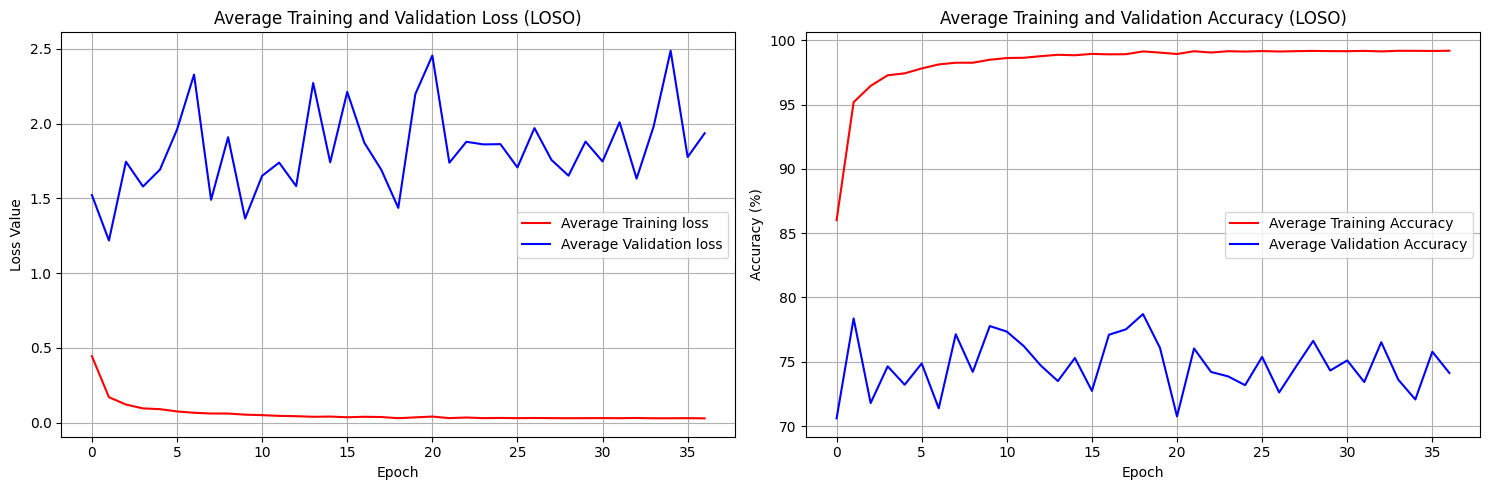

In [ ]:
# Aggregate and Visualize Final Results
max_len = max(len(l) for l in all_train_losses)
padded_train_losses = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_train_losses])
padded_val_losses = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_val_losses])
padded_train_accuracies = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_train_accuracies])
padded_val_accuracies = np.array([l + [l[-1]] * (max_len - len(l)) for l in all_val_accuracies])

avg_train_loss = np.mean(padded_train_losses, axis=0)
avg_val_loss = np.mean(padded_val_losses, axis=0)
avg_train_acc = np.mean(padded_train_accuracies, axis=0)
avg_val_acc = np.mean(padded_val_accuracies, axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, 'r', label='Average Training loss')
plt.plot(avg_val_loss, 'b', label='Average Validation loss')
plt.title('Average Training and Validation Loss (LOSO)')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, 'r', label='Average Training Accuracy')
plt.plot(avg_val_acc, 'b', label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy (LOSO)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Final Classification Report (Aggregated LOSO) ---
                   precision    recall  f1-score   support

            lying     0.5655    0.8126    0.6669      2433
          sitting     0.7094    0.5716    0.6331      2374
         standing     0.5805    0.3276    0.4188      2378
          walking     0.7784    0.5753    0.6616      2882
          running     0.7045    0.7358    0.7198      1889
          cycling     0.9037    0.5862    0.7111      2385
   Nordic walking     0.7834    0.4116    0.5397      2636
 ascending stairs     0.6297    0.7864    0.6994      1451
descending stairs     0.2311    0.7182    0.3496      1274
  vacuum cleaning     0.6096    0.8246    0.7010      2269
          ironing     0.6875    0.5238    0.5946      3125
     rope jumping     0.2322    0.2561    0.2436       855

         accuracy                         0.5945     25951
        macro avg     0.6180    0.5942    0.5783     25951
     weighted avg     0.6618    0.5945    0.6020     25951

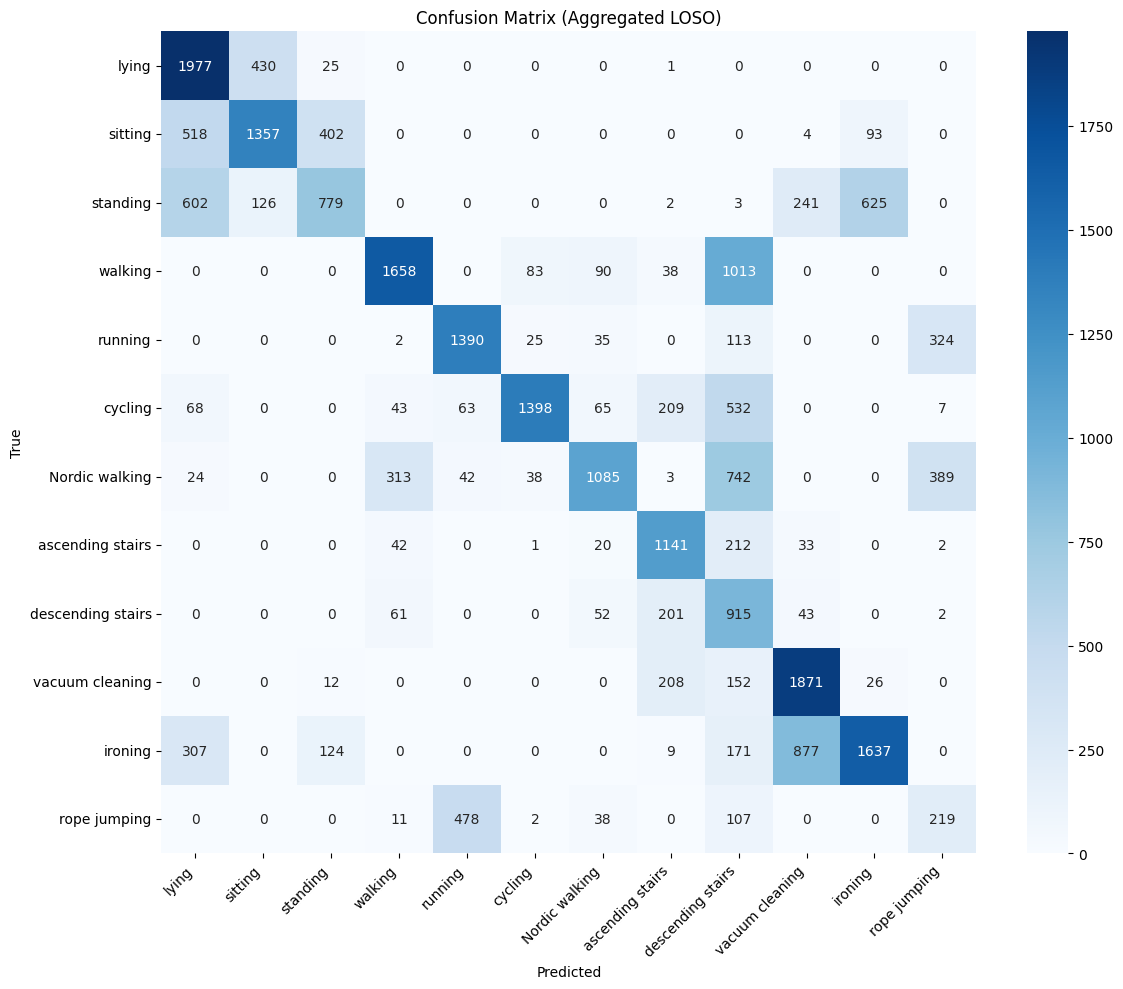

In [ ]:
# Final Classification Report and Confusion Matrix
print("\n--- Final Classification Report (Aggregated LOSO) ---")
LABELS = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling',
          'Nordic walking', 'ascending stairs', 'descending stairs',
          'vacuum cleaning', 'ironing', 'rope jumping']
target_names = [LABELS[i] for i in np.unique(all_labels)]
print(classification_report(all_labels, all_preds, digits=4, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated LOSO)')
plt.gca().set_xticklabels(target_names, rotation=45, ha='right')
plt.gca().set_yticklabels(target_names, rotation=0)
plt.tight_layout()
plt.show()